In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec #Useful tool to arrange multiple plots in one figure (https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html)

%matplotlib inline

import platform
platstring = platform.platform()

data_dirname = 'visual-behavior-neuropixels'
use_static = False
if 'Darwin' in platstring or 'macOS' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2021/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/"
    data_dirname = 'visual-behavior-neuropixels-data'
    use_static = True
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/home/andrew/Documents/tmp/5-1-24-change-detection"

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# this path determines where downloaded data will be stored
manifest_path = os.path.join(data_root, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

print(cache.get_all_session_types())



/home/andrew/Documents/projects/swdb_2022/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['brain_observatory_1.1', 'functional_connectivity']


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def get_time_window(session, buffer=1):
    """
    Get the time window from slightly before the first flash to slightly after the third flash.
    
    Parameters:
        session (EcephysSession): The session object.
        buffer (float): Buffer time in seconds to extend before the first and after the last flash.
    
    Returns:
        tuple: start_time, end_time
    """
    num_flashes = 50
    flashes = session.get_stimulus_table("flashes").head(num_flashes)

    print("number of flashes!!!-------------")
    print(len(flashes))
    if len(flashes) != num_flashes:
        print("++++++++++++++++++BIG BIG ISSUE NUM FLASHES NOT CONSISTENT")
        exit(1)

    num_flashes = min(num_flashes, len(flashes))
    start_time = flashes.iloc[0]['start_time'] - buffer
    end_time = flashes.iloc[num_flashes-1]['stop_time'] + buffer

    flash_start_times = flashes['start_time'].values
    flash_end_times = flashes['stop_time'].values

    print("number of flash starts")
    print(len(flash_start_times))
    print("number of flash ends")
    print(len(flash_end_times))
    if len(flash_start_times) != len(flash_end_times) and len(flash_start_times) != num_flashes:
        print("++++++++++++++++++BIG BIG ISSUE NUM FLASHES NOT CONSISTENT")
        exit(1)

    return start_time, end_time, flash_start_times, flash_end_times

def extract_and_bin_spikes(session, start_time, end_time, bin_size, regions, flash_start_times, flash_end_times):
    """
    Extract spikes for each region within a defined time window and bin them.
    
    Parameters:
        session (EcephysSession): The session object.
        start_time (float): Start time of the window.
        end_time (float): End time of the window.
        bin_size (float): Bin size in seconds.
        regions (list): List of regions to include in the analysis.
    
    Returns:
        dict: A dictionary containing binned firing rates for each region.
    """
    binned_flash_starts, _ = np.histogram(flash_start_times, bins=np.arange(start_time, end_time, bin_size))
    binned_flash_ends, _ = np.histogram(flash_end_times, bins=np.arange(start_time, end_time, bin_size))

    # print()
    # print("+++")
    # print("number of flash start times: ", len(flash_start_times))
    # print("number of binned flash starts: ", len(binned_flash_starts))
    # print("number of binned flash start times that are not zero: ", len(binned_flash_starts[binned_flash_starts > 0]))
    # flash_indices = np.where(binned_flash_starts == 1)[0]
    # print("flash indices: ", flash_indices)
    # print("len flash indices: ", len(flash_indices))
    # if len(flash_indices) != len(flash_start_times):
    #     print("++++++++++++++++++BIG BIG ISSUE NUM FLASHES NOT CONSISTENT")
    #     exit(1)
    # flash_indices = np.where(binned_flash_starts == 1)
    # print("flash indices no index: ", flash_indices)
    # print("+++")
    # print()

    region_data = {region: [] for region in regions}

    # print("spike times")
    # print(session.spike_times)
    # print("units")
    # print(session.units.columns)
    for unit_id, spikes in session.spike_times.items():
        region = session.units.loc[unit_id, 'ecephys_structure_acronym']
        if region in regions:
            binned_spikes, times = np.histogram(spikes, bins=np.arange(start_time, end_time, bin_size))
            # region_data[region].append(pd.Series(binned_spikes / bin_size, name=unit_id, index=times[:-1]))
            region_data[region].append(pd.Series(binned_spikes / bin_size, name=unit_id))

    # Average across units in each region or provide zeros where no data exists
    for region in regions:
        if region_data[region]:
            region_data[region] = pd.concat(region_data[region], axis=1).mean(axis=1)
        else:
            # Initialize the series with zeros for each time binS
            print("------------------------alert missing region data: ", region)
            # print(region)
            region_data[region] = pd.Series(np.zeros(len(np.arange(start_time, end_time, bin_size)[:-1])))

    return region_data, binned_flash_starts, binned_flash_ends


# def plot_firing_rates(region_data, bin_size, average_flash_starts, average_flash_ends):
#     """
#     Plot the firing rates over time for each region, ensuring data alignment.

#     Parameters:
#         region_data (dict): Dictionary containing firing rates binned over time for each region.
#         bin_size (float): Bin size used in seconds.
#     """
#     plt.figure(figsize=(12, 8))

#     for region, data in region_data.items():
#         if not data.empty:
#             # Generate time bins based on the data index
#             time_bins = np.linspace(data.index[0], data.index[-1], num=len(data))
            
#             # Plotting each region's data
#             plt.plot(time_bins, data.values, label=f'Region: {region}')
#         else:
#             # Handle cases where there is no data for a region
#             print(f"---------------No data available for region {region}")

#     plt.xlabel('Time (s)')
#     plt.ylabel('Firing Rate (spikes/s)')
#     plt.title('Average Firing Rate Over Time by Region Across Selected Sessions')
#     plt.legend()
#     plt.show()

# Main analysis for two selected sessions
sessions = cache.get_session_table()
brain_observatory_type_sessions = sessions[sessions["session_type"] == "brain_observatory_1.1"]
# selected_sessions = brain_observatory_type_sessions.head(600)  # Select only the first two sessions
selected_sessions = sessions.head(600)  # Select only the first two sessions
print(len(selected_sessions))

regions = ["LGd", "LGv", "LP", "VISp", "VISl", "VISal", "VISrl", "VISpm", "VISam"]
# IMPORTANT: If we change this, we need to change plotting code which infers the bin size!
bin_size = 0.005  # Example bin size of 100ms

# Collect data from all selected sessions
per_unit_counts = {region: [] for region in regions}
all_region_data = {region: [] for region in regions}
blank_regions = {region: 0 for region in regions}
all_binned_flash_starts = []
all_binned_flash_ends = []
count = -1
for session_id in selected_sessions.index:
    count += 1

    # # skip known bad sessions that don't have all regions
    # if count in [0, 3, 4, 5, 6, 7]:
    #     continue



    session = cache.get_session_data(session_id)

    count_structure_acronyms = session.units['structure_acronym'].value_counts()
    for region in regions:
        per_unit_counts[region].append(count_structure_acronyms.get(region, 0))
        # print(f"Region: {region}, Count: {count_structure_acronyms.get(region, 0)}")

    start_time, end_time, flash_start_times, flash_end_times = get_time_window(session)
    print("start_time, end_time")
    print(start_time, end_time)
    region_data, binned_flash_starts, binned_flash_ends = extract_and_bin_spikes(session, start_time, end_time, bin_size, regions, flash_start_times, flash_end_times)

    if not all(len(df) == 20066 for df in region_data.values()):
        print("BIG PROBLEM BINS DON't MATCH: ", len(region_data["VISp"]))
        break

    for region in regions:
        if not region_data[region].any():
            print(f"{region} bumping empty count for region", region)
            blank_regions[region] += 1

    # should_continue = False
    # for region in regions:
    #     if not region_data[region].any():
    #         print(f"{region} region_data[region].any(): ", region_data[region])
    #         print("------skipping where no data: ", region)
    #         should_continue = True
    #         break
    # if should_continue:
    #     continue

    for region in regions:
        all_region_data[region].append(region_data[region])

    all_binned_flash_starts.append(binned_flash_starts)
    all_binned_flash_ends.append(binned_flash_ends)

    # # TODO: delete this  
    # if count == 2:
    #     break

# print(all_region_data["VISp"])

# print(f"region_data: { region_data }")


58


/home/andrew/Documents/projects/swdb_2022/env/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/andrew/Documents/projects/swdb_2022/env/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/home/andrew/Documents/projects/swdb_2022/env/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/andrew/Documents/projects/swdb_2022/env/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/home/andrew/Documents/projects/swdb_2022/env/lib/python3.11/site-

number of flashes!!!-------------
50
number of flash starts
50
number of flash ends
50
start_time, end_time
1273.5239729367065 1373.8561440768335
------------------------alert missing region data:  LGv
------------------------alert missing region data:  VISal
LGv bumping empty count for region LGv
VISal bumping empty count for region VISal
VISam bumping empty count for region VISam
number of flashes!!!-------------
50
number of flash starts
50
number of flash ends
50
start_time, end_time
1289.8830973815907 1390.2152563127247
------------------------alert missing region data:  LGv
LGv bumping empty count for region LGv
number of flashes!!!-------------
50
number of flash starts
50
number of flash ends
50
start_time, end_time
1286.272022141096 1386.6041136429385
------------------------alert missing region data:  LGd
------------------------alert missing region data:  VISpm
LGd bumping empty count for region LGd
VISpm bumping empty count for region VISpm
number of flashes!!!-------------

num flashes:  34
Number of time steps before first flash: 199
Number of time steps after last flash: 250
Chunk size: 449
Length of average_region_data_cp['VISam']: 20066
---
(1088, 449)
(449,)
---
---
(408, 449)
(449,)
---
---
(1428, 449)
(449,)
---
---
(1870, 449)
(449,)
---
---
(1428, 449)
(449,)
---
---
(1496, 449)
(449,)
---
---
(1666, 449)
(449,)
---
---
(1190, 449)
(449,)
---
---
(1666, 449)
(449,)
---
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.

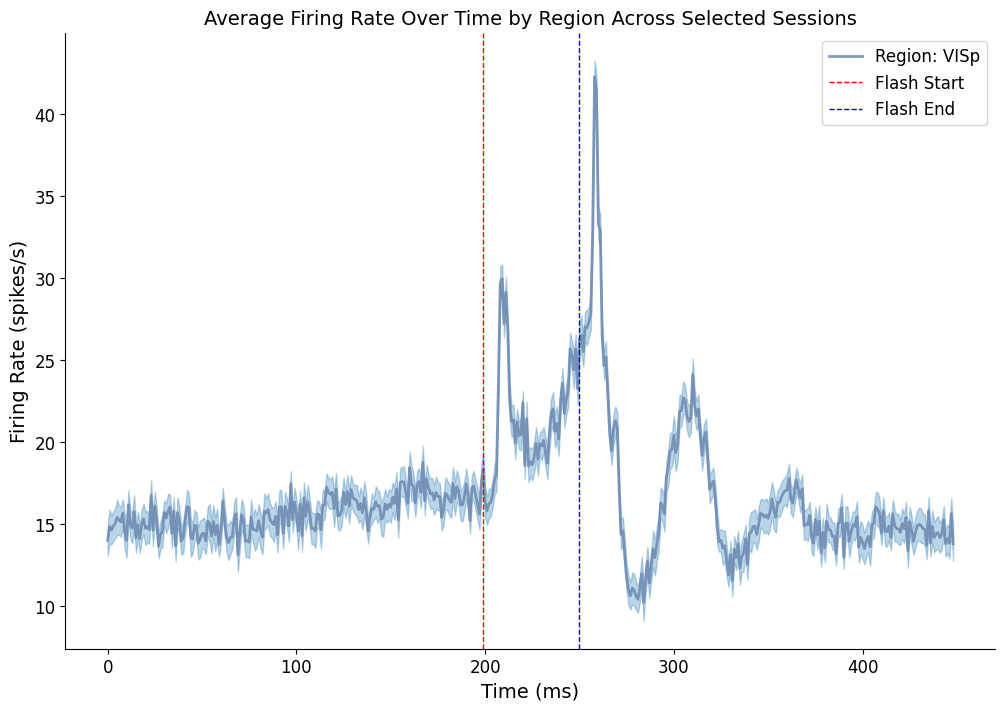

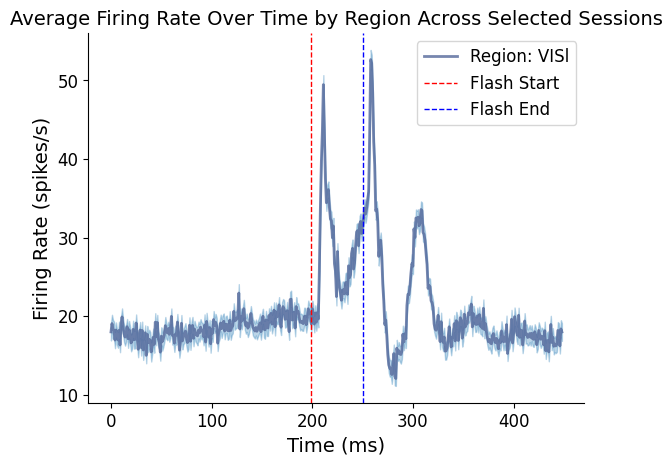

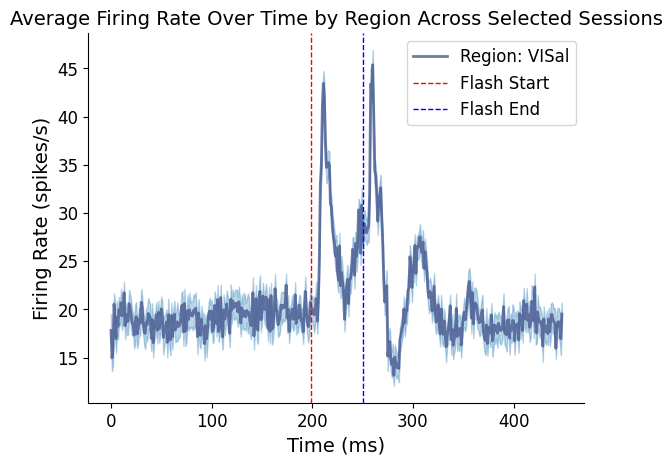

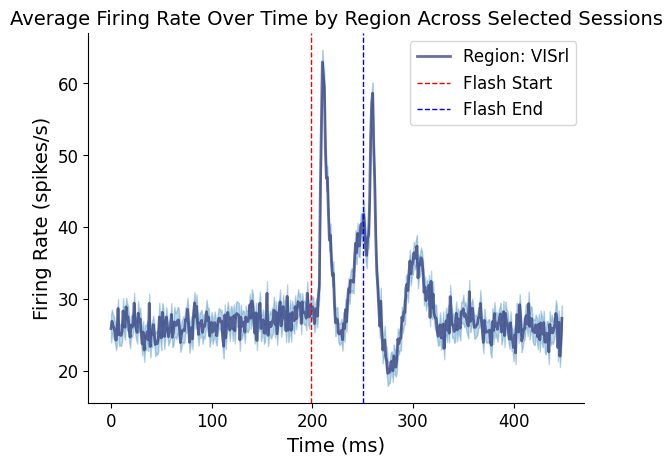

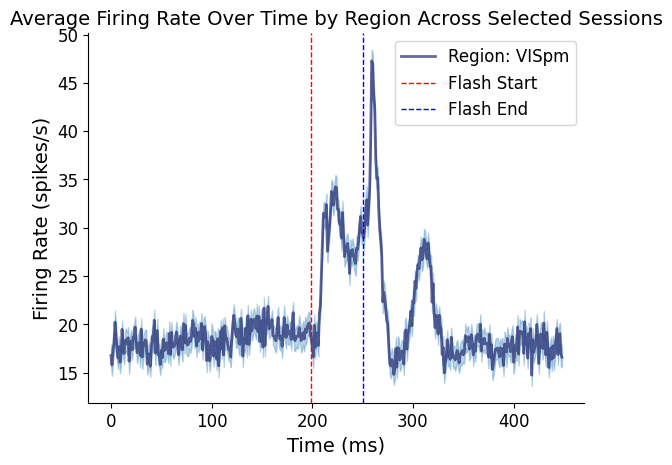

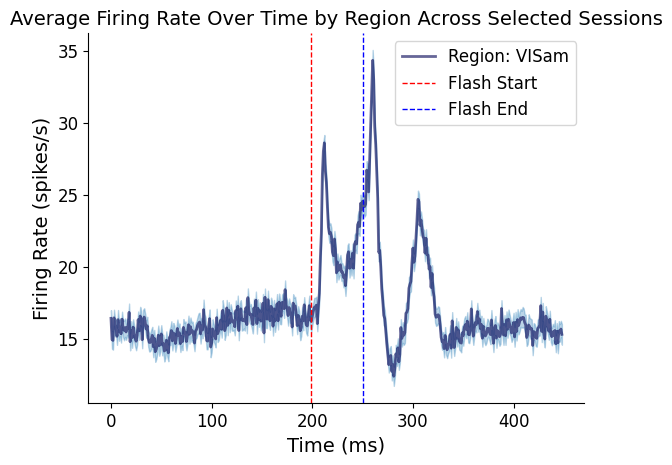

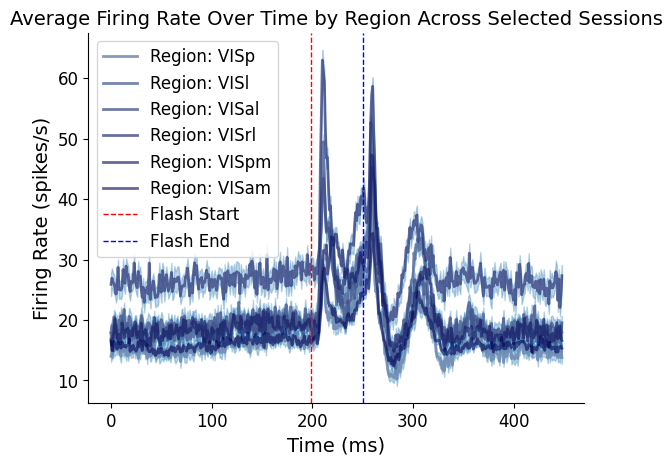

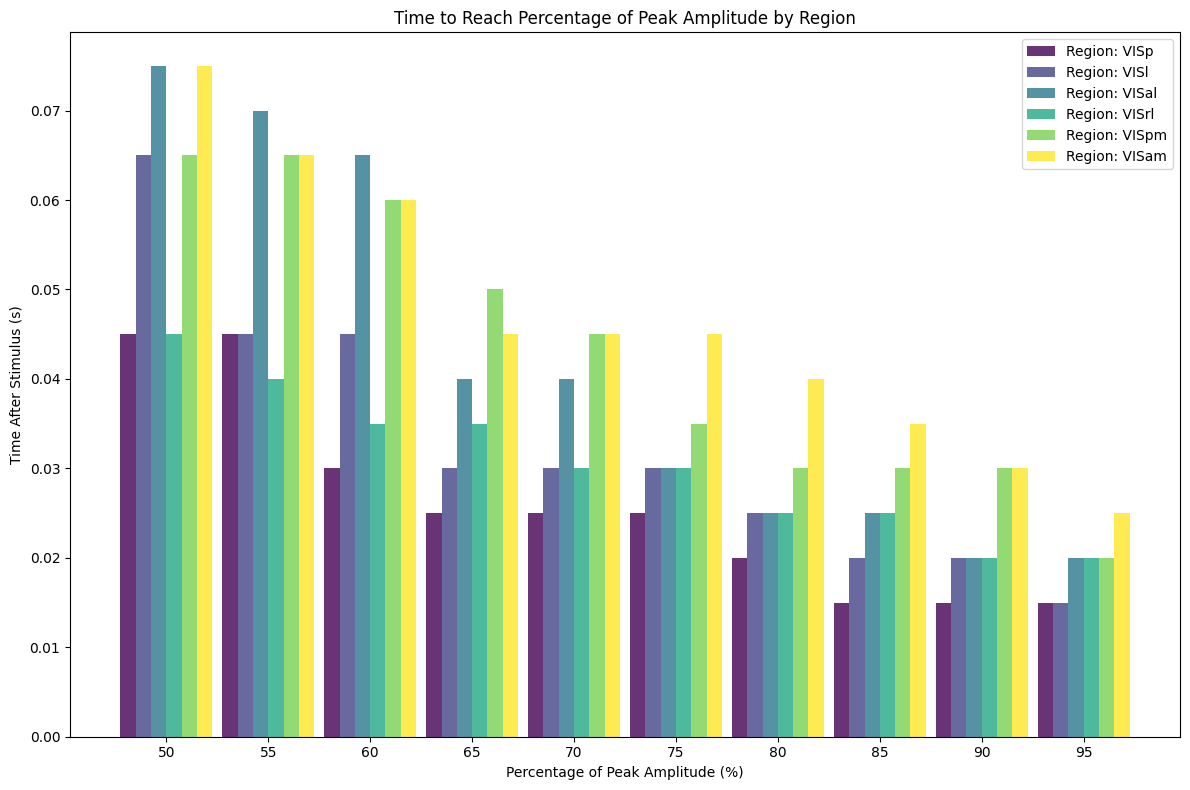

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, to_rgba

def plot_firing_rates(region_data, bin_size, average_flash_starts, average_flash_ends, flash_offset, std_err_data):
    """
    Plot the firing rates over time for each region, ensuring data alignment,
    and add vertical lines for average flash starts and ends based on a binary indicator.

    Parameters:
        region_data (dict): Dictionary containing firing rates binned over time for each region.
        bin_size (float): Bin size used in seconds.
        average_flash_starts (array): Array of binary values indicating flash starts.
        average_flash_ends (array): Array of binary values indicating flash ends.
        flash_offset (float): Offset to align the flash indicators correctly with the time bins.
    """
    print(average_flash_starts - average_flash_ends)
    plt.figure(figsize=(12, 8))

    # Define a blue colormap that scales from dark to light
    # colors = LinearSegmentedColormap.from_list("blue_grad", ["#1f77b4", "#08306b"], N=len(region_data))
    # color_map = {region: colors(i / len(region_data)) for i, region in enumerate(region_data.keys())}

    # Get the original darkblue color
    darkblue = to_rgba("darkblue")

    # Calculate the new darkblue color with 60% intensity
    new_darkblue = tuple(0.6 * c for c in darkblue)

    # Create the modified colormap
    colors = LinearSegmentedColormap.from_list("blue_grad", ["lightblue", new_darkblue], N=20)

    # colors = LinearSegmentedColormap.from_list("blue_grad", ["lightblue", "darkblue"], N=20)

    color_map = {region: colors(i / (len(region_data) - 1)) for i, region in enumerate(region_data.keys())}
    # color_map = {region: colors(i) for i, region in enumerate(regions)}

    # start_bin = 257 * 1
    # end_bin = 280 * 1
    start_bin = 0
    end_bin = 10000

    regions_for_fn = ["VISp", "VISl", "VISal", "VISrl", "VISpm", "VISam"]

    for region_0 in regions_for_fn:
        for i, (region, data) in enumerate(region_data.items()):
            if region not in [region_0]:
                continue

            if not data.empty:
                time_bins = np.linspace(data.index[0], data.index[-1], num=len(data))
                sliced_time_bins = time_bins[start_bin:end_bin]
                # sliced_time_bins = (time_bins - time_bins[start_bin]) * bin_size * 1000
                sliced_data = data.values[start_bin:end_bin] / bin_size
                
                std_err = std_err_data[region].values[start_bin:end_bin] / bin_size

                plt.plot(sliced_time_bins, sliced_data, label=f'Region: {region}', color=color_map[region], linewidth=2)
                plt.fill_between(sliced_time_bins, sliced_data - std_err, sliced_data + std_err, alpha=0.3, color="#1f77b4")
            else:
                print(f"No data available for region {region}")

        average_flash_starts = average_flash_starts
        average_flash_ends = average_flash_ends

        for bin_num, (flash_start, flash_end) in enumerate(zip(average_flash_starts[start_bin:end_bin], average_flash_ends[start_bin:end_bin])):
            if flash_start == 1:
                plt.axvline(x=flash_offset + bin_num + start_bin, color='r', linestyle='--', linewidth=1, label='Flash Start' if 'Flash Start' not in plt.gca().get_legend_handles_labels()[1] else "")
            if flash_end == 1:
                plt.axvline(x=flash_offset + bin_num + start_bin, color='b', linestyle='--', linewidth=1, label='Flash End' if 'Flash End' not in plt.gca().get_legend_handles_labels()[1] else "")

        plt.xlabel('Time (ms)', fontsize=14)
        plt.ylabel('Firing Rate (spikes/s)', fontsize=14)
        plt.title('Average Firing Rate Over Time by Region Across Selected Sessions', fontsize=14)
        plt.legend(fontsize=12)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.grid(False)
        plt.show()

    for i, (region, data) in enumerate(region_data.items()):
        if region not in regions_for_fn:
            continue

        if not data.empty:
            time_bins = np.linspace(data.index[0], data.index[-1], num=len(data))
            sliced_time_bins = time_bins[start_bin:end_bin]
            # sliced_time_bins = (time_bins - time_bins[start_bin]) * bin_size * 1000
            sliced_data = data.values[start_bin:end_bin] / bin_size
            std_err = std_err_data[region].values[start_bin:end_bin] / bin_size

            plt.plot(sliced_time_bins, sliced_data, label=f'Region: {region}', color=color_map[region], linewidth=2)
            plt.fill_between(sliced_time_bins, sliced_data - std_err, sliced_data + std_err, alpha=0.3, color="#1f77b4")
        else:
            print(f"No data available for region {region}")

    # for bin_num, (flash_start, flash_end) in enumerate(zip(average_flash_starts_for_fn[start_bin:end_bin], average_flash_ends_for_fn[start_bin:end_bin])):
    #     if flash_start == 1:
    #         plt.axvline(x=flash_offset + bin_num * 5, color='r', linestyle='--', linewidth=1, label='Flash Start' if 'Flash Start' not in plt.gca().get_legend_handles_labels()[1] else "")
    #     if flash_end == 1:
    #         plt.axvline(x=flash_offset + bin_num * 5, color='b', linestyle='--', linewidth=1, label='Flash End' if 'Flash End' not in plt.gca().get_legend_handles_labels()[1] else "")

    for bin_num, (flash_start, flash_end) in enumerate(zip(average_flash_starts[start_bin:end_bin], average_flash_ends[start_bin:end_bin])):
        if flash_start == 1:
            plt.axvline(x=flash_offset + bin_num + start_bin, color='r', linestyle='--', linewidth=1, label='Flash Start' if 'Flash Start' not in plt.gca().get_legend_handles_labels()[1] else "")
        if flash_end == 1:
            plt.axvline(x=flash_offset + bin_num + start_bin, color='b', linestyle='--', linewidth=1, label='Flash End' if 'Flash End' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('Time (ms)', fontsize=14)
    plt.ylabel('Firing Rate (spikes/s)', fontsize=14)
    plt.title('Average Firing Rate Over Time by Region Across Selected Sessions', fontsize=14)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(False)
    plt.show()




pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

regions = ["LGd", "LGv", "LP", "VISp", "VISl", "VISal", "VISrl", "VISpm", "VISam"]

# for region in regions:
# # blank_regions[region]) / count_structure_acronyms[region]
#     if region not in blank_regions:
#         blank_regions[region] = 0
#     if region not in count_structure_acronyms:
#         print("WARN: region not in count_structure_acronyms: ", region)
#         count_structure_acronyms[region] = 0

truncate_pre = 0
truncate = 100000

# print("len(all_region_data['VISp']): ", len(all_region_data["VISp"]))
# print("len(all_region_data['VISp'][0]): ", len(all_region_data["VISp"][0]))

# flash_indices = np.where(all_binned_flash_starts[0] == 1)[0]
# print("number of flashes: ", len(flash_indices))


all_binned_flash_starts_cp = []
for i in range(len(all_binned_flash_starts)):
    all_binned_flash_starts_cp.append(all_binned_flash_starts[i][truncate_pre:truncate])

# print("len(all_binned_flash_starts_cp): ", len(all_binned_flash_starts_cp))
# print("len(all_binned_flash_starts_cp[0]): ", len(all_binned_flash_starts_cp[0]))

average_flash_starts = np.mean(all_binned_flash_starts_cp, axis=0)
average_flash_ends = np.mean(all_binned_flash_ends, axis=0)

# flash_indices = np.where(average_flash_starts not in [0, 1])[0]
# print("number of flashes: ", len(flash_indices))
# print("----flash indices: ", flash_indices)

# determine from flash starts how many timesteps before first flash
num_time_steps_before_first_flash = np.where(average_flash_starts == 1)[0][0]
# print(num_time_steps_before_first_flash)

# determine from flash starts how many timesteps after last flash
num_time_steps_after_last_flash = len(average_flash_starts) - np.where(average_flash_starts == 1)[0][-1]
# print(num_time_steps_after_last_flash)

# print(average_flash_starts)

# print(len(all_region_data["VISp"]))
# print(len(all_region_data["VISp"][0]))
# print()
all_region_data_cp = {}
for region in regions:
    all_region_data_cp[region] = []
    for series in all_region_data[region]:
        all_region_data_cp[region].append(series[truncate_pre:truncate])

# average_region_data_cp = {region: pd.concat(all_region_data_cp[region], axis=1).mean(axis=1) for region in regions}

    # iterate through all region data cp
        # for each region data cp[region][session][index] divide by number of units

# normalize based on number of units
normalized_region_data_cp = {}
std_err_data = {}
for region in all_region_data_cp:
    region_data_normalized_by_nuits = []
    for i, session_data in enumerate(all_region_data_cp[region]):
        build = []
        for measurement in session_data:
            if per_unit_counts[region][i] == 0:
                assert measurement == 0
                build.append(0)
            else:
                build.append(measurement/per_unit_counts[region][i])
        region_data_normalized_by_nuits.append(pd.Series(build))
    normalized_region_data_cp[region] = region_data_normalized_by_nuits

    # TODO: perform this calculation without zeros in the dataset
    # Calculate the standard error after normalization and before averaging
    concatenated_normalized_data = pd.concat(normalized_region_data_cp[region], axis=1)
    non_zero_columns = concatenated_normalized_data.loc[:, (concatenated_normalized_data != 0).any(axis=0)]
    # print(concatenated_normalized_data.shape)
    # print(non_zero_columns.shape)

    # std_err_data[region] = non_zero_columns

    # std_err_data[region] = non_zero_columns.std(axis=1) / np.sqrt(non_zero_columns.shape[1])
    std_err_data[region] = non_zero_columns

    # 
    # print("-----------")
    # print(std_err_data[region].shape)
    # # print(std_err_data[region][0])
    # # print(std_err_data[region][1])
    # print(concatenated_normalized_data.shape[1])
    # print(concatenated_normalized_data.std(axis=1).shape)
    # print("++++++++")
    # print(normalized_region_data_cp[region][0].shape)
    # print(std_err_data[region][0])
    # print(normalized_region_data_cp[region][0].shape)


# account for blank regions
average_region_data_cp = {}
for region in normalized_region_data_cp:
    num_sessions = len(normalized_region_data_cp[region])
    # average_region_data_cp[region] = pd.concat(normalized_region_data_cp[region], axis=1).sum(axis=1)
    average_region_data_cp[region] = pd.concat(normalized_region_data_cp[region], axis=1)
    non_zero_columns_blank_calcs = average_region_data_cp[region].loc[:, (average_region_data_cp[region] != 0).any(axis=0)]
    average_region_data_cp[region] = non_zero_columns_blank_calcs.sum(axis=1) / non_zero_columns_blank_calcs.shape[1]
    # print(f"num sessions / blank regions: {num_sessions} / {blank_regions[region]}")
    # for i in range(0, len(average_region_data_cp[region])):
    #     average_region_data_cp[region][i] = average_region_data_cp[region][i] / (num_sessions - blank_regions[region])

flash_indices = np.where(average_flash_starts == 1)[0]
num_flashes = len(flash_indices)
print("num flashes: ", num_flashes)
chunk_size = num_time_steps_before_first_flash + num_time_steps_after_last_flash

print("Number of time steps before first flash:", num_time_steps_before_first_flash)
print("Number of time steps after last flash:", num_time_steps_after_last_flash)
print("Chunk size:", chunk_size)

print("Length of average_region_data_cp['VISam']:", len(average_region_data_cp["VISam"]))



overlaid_region_data = {}
for region in regions:
    overlaid_chunks = []
    # IMPORTANT: how flashes to ignore
    for i in range(3, num_flashes):
        start_index = flash_indices[i] - num_time_steps_before_first_flash
        end_index = start_index + chunk_size
        chunk = average_region_data_cp[region].iloc[start_index:end_index].reset_index(drop=True)  # Reset index here
        overlaid_chunks.append(chunk)

    overlaid_chunks_concat = pd.concat(overlaid_chunks, axis=1)
    num_chunks = overlaid_chunks_concat.shape[1]
    overlaid_chunks_sum = overlaid_chunks_concat.sum(axis=1)
    for i in range(len(overlaid_chunks_sum)):
        overlaid_chunks_sum[i] = overlaid_chunks_sum[i] / (num_chunks)

    overlaid_region_data[region] = overlaid_chunks_sum

    # trim the last few elements off of std_err_data for region
    std_err_data[region] = std_err_data[region].iloc[0:chunk_size * num_flashes]

    # calculate std err by overlapping chunks
    # print(std_err_data[region].shape)
    # print(std_err_data[region].shape[0] % chunk_size)
    # print(std_err_data[region].shape[1])
    std_err_data[region] = std_err_data[region].values.reshape(-1, chunk_size, std_err_data[region].shape[1])
    std_err_data[region] = std_err_data[region].transpose(2, 0, 1)
    shape_for_std_err_calc = std_err_data[region].shape
    std_err_data[region] = std_err_data[region].reshape(shape_for_std_err_calc[0] * shape_for_std_err_calc[1], shape_for_std_err_calc[2])
    std_err_data[region] = pd.DataFrame(std_err_data[region])
    print("---")
    print(std_err_data[region].shape)
    std_err_data[region] = std_err_data[region].std(axis=0) / np.sqrt(std_err_data[region].shape[0])
    print(std_err_data[region].shape)
    print("---")

# print("VISpm: ", overlaid_region_data["VISpm"])

# TODO: This needs to move on top in beginning before we calculate std_err!!!!!!!!
# # by region, average overlaid region data by the average over timesteps 0-190
# region_averages = {}
# end_average_timestep = 180
# for region in regions:
#     running_sum = 0
#     for i in range(0, end_average_timestep):
#         running_sum += overlaid_region_data[region][i]
#     average = running_sum / end_average_timestep
#     region_averages[region] = average

# # subtract by the average over timesteps 0-190
# for region in regions:
#     for i in range(0, len(overlaid_region_data[region])):
#         overlaid_region_data[region][i] = overlaid_region_data[region][i] - region_averages[region]


average_flash_starts = average_flash_starts[0:chunk_size]
average_flash_ends = average_flash_ends[0:chunk_size]
plot_firing_rates(overlaid_region_data, bin_size, average_flash_starts, average_flash_ends, flash_offset=truncate_pre, std_err_data=std_err_data)

def find_peak_amplitude(data, margin):
    max_value = data.max()
    peak_amplitude = max_value
    for i in range(len(data) - 1, -1, -1):
        if data.iloc[i] >= max_value - margin:
            peak_amplitude = data.iloc[i]
            break
    return peak_amplitude

def find_time_to_percent_peak(data, peak_value, percent, start_bin, end_bin):
    target_value = peak_value * percent
    peak_reached = False
    for i in range(len(data)):
        if not peak_reached and data.iloc[i] == peak_value:
            peak_reached = True
        if peak_reached and data.iloc[i] <= target_value:
            return data.index[i]
    return -1

start_bin = 257
end_bin = 280
margin = 0.0125  # Adjust this value according to your needs

plt.figure(figsize=(12, 8))

percentages = np.arange(0.50, 0.96, 0.05)
bar_width = 0.15
opacity = 0.8

regions = ["VISp", "VISl", "VISal", "VISrl", "VISpm", "VISam"]
colors = plt.cm.viridis(np.linspace(0, 1, len(regions)))

for i, region in enumerate(regions):
    data = overlaid_region_data[region]
    sliced_data = data[start_bin:end_bin]
    peak_amplitude = find_peak_amplitude(sliced_data, margin)
    time_to_percent_peak = []

    for percent in percentages:
        time = find_time_to_percent_peak(sliced_data, peak_amplitude, percent, start_bin, end_bin)
        if time != -1:
            time_to_percent_peak.append((time - start_bin) * bin_size)
        else:
            time_to_percent_peak.append(np.nan)

    index = np.arange(len(percentages))
    plt.bar(index + i * bar_width, time_to_percent_peak, bar_width, alpha=opacity, color=colors[i], label=f'Region: {region}')

plt.xlabel('Percentage of Peak Amplitude (%)')
plt.ylabel('Time After Stimulus (s)')
plt.title('Time to Reach Percentage of Peak Amplitude by Region')
plt.xticks(index + bar_width * (len(regions) - 1) / 2, (percentages * 100).astype(int))
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#########################################################

num flashes:  34
Number of time steps before first flash: 199
Number of time steps after last flash: 250
Chunk size: 449
Length of average_region_data_cp['VISam']: 20066
---
(1088, 449)
(449,)
---
---
(408, 449)
(449,)
---
---
(1428, 449)
(449,)
---
---
(1870, 449)
(449,)
---
---
(1428, 449)
(449,)
---
---
(1496, 449)
(449,)
---
---
(1666, 449)
(449,)
---
---
(1190, 449)
(449,)
---
---
(1666, 449)
(449,)
---
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.

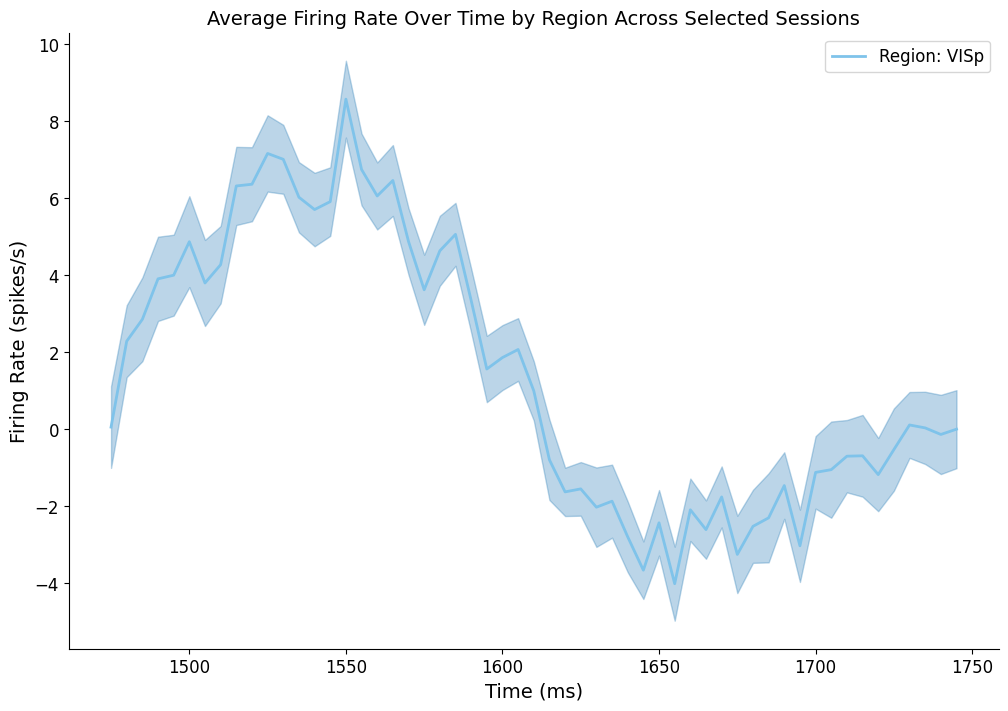

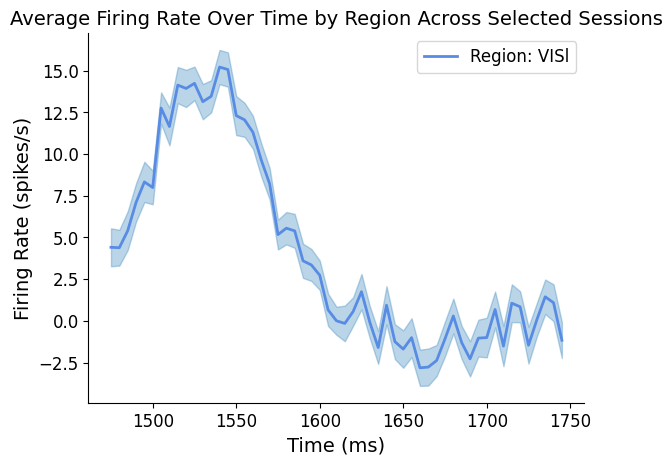

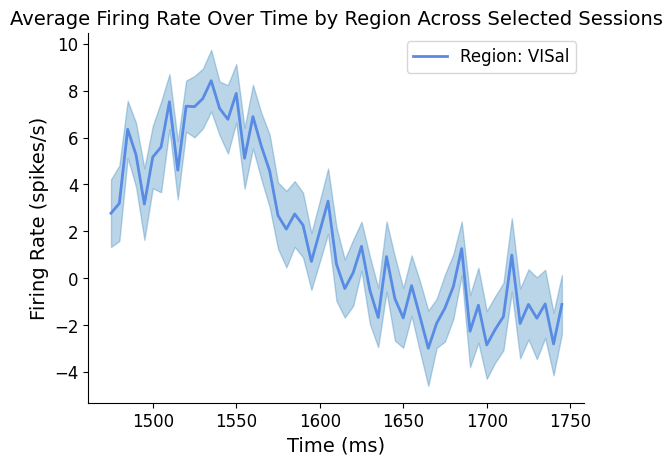

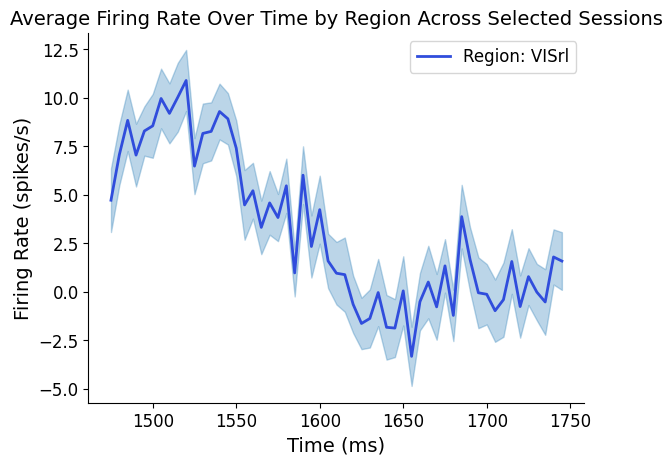

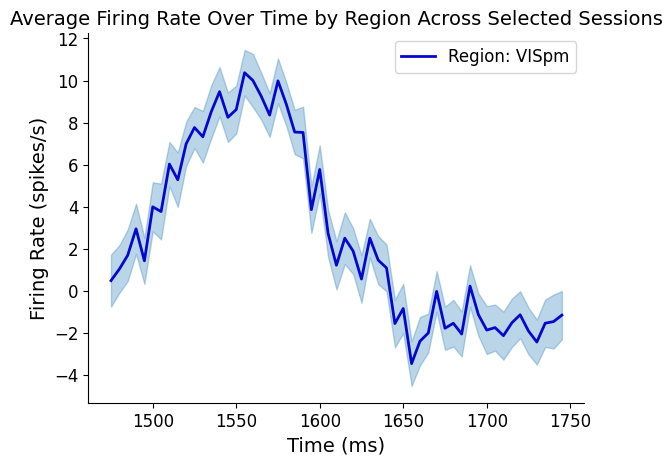

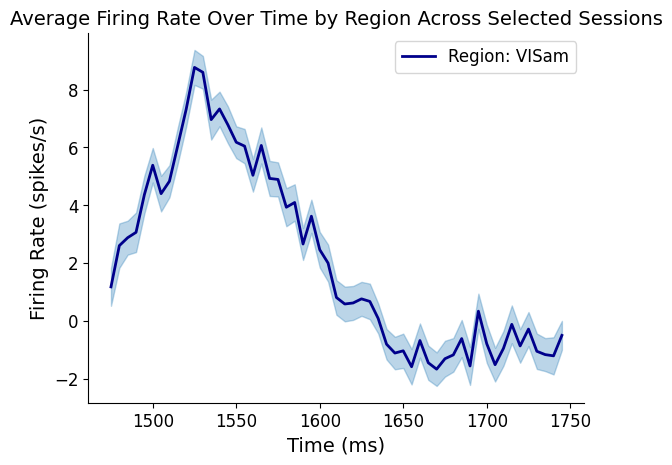

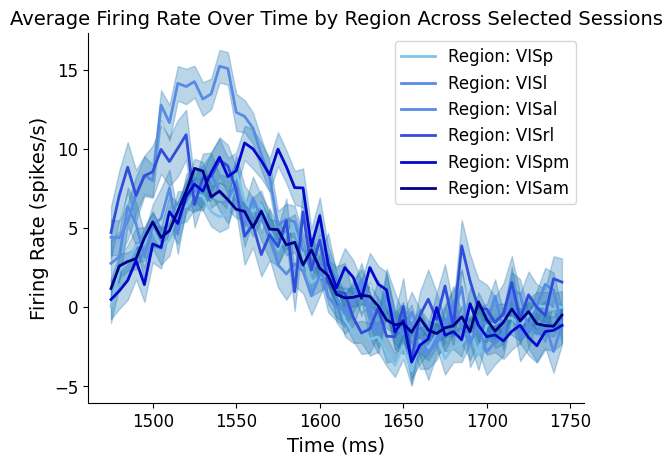

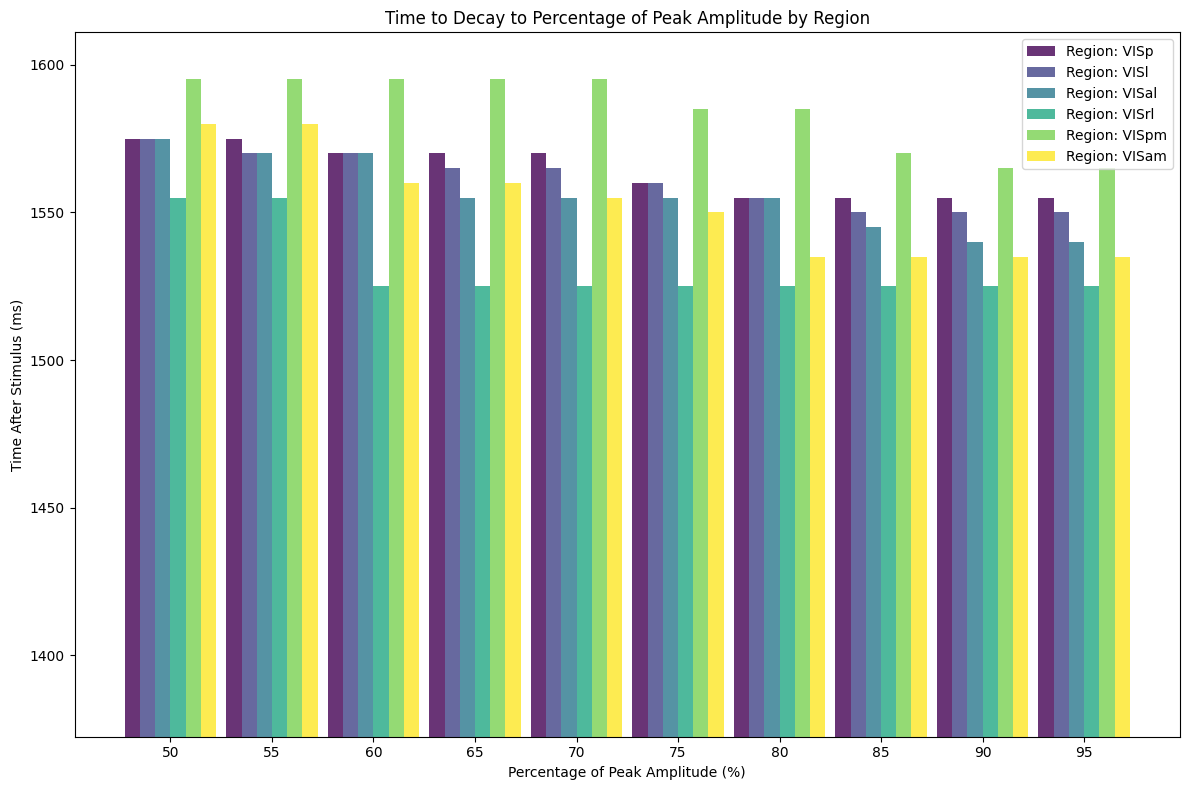

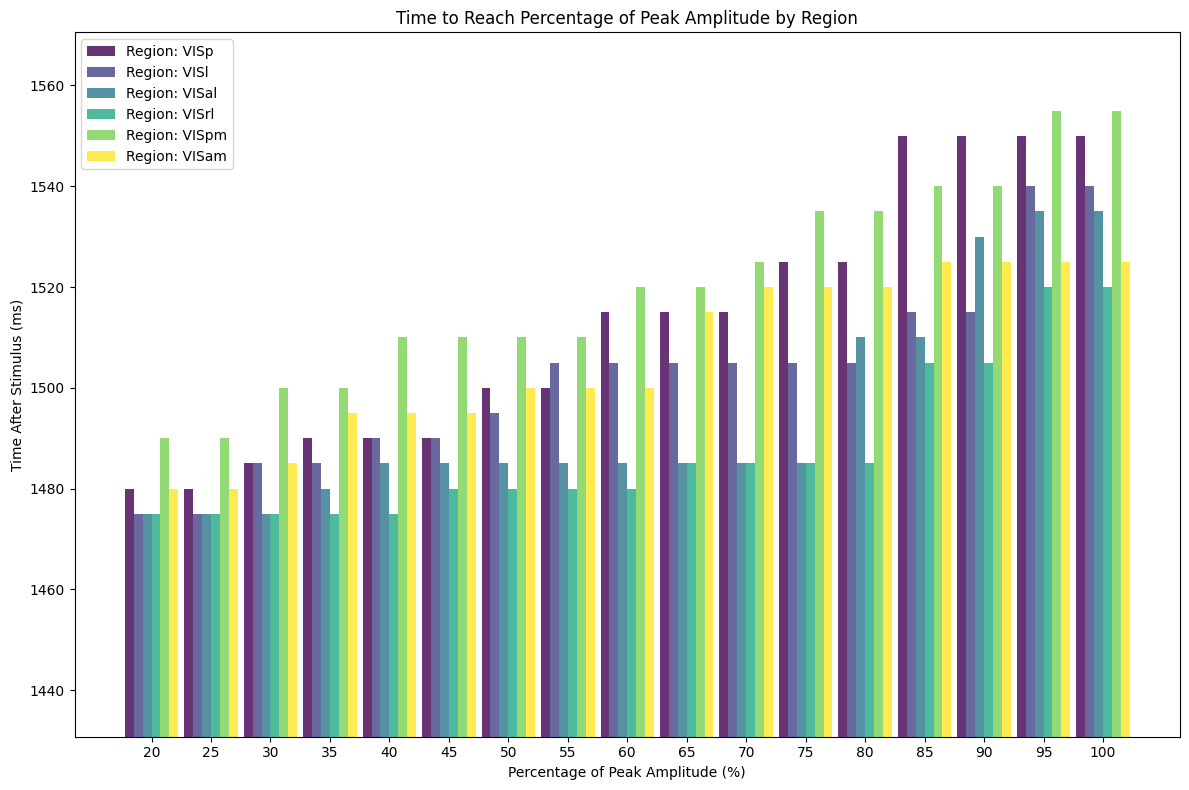

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, to_rgba

# ALL
# start_bin = 0
# end_bin = 10000

# FLASH ON RISE
# start_bin = 203
# end_bin = 232

# FLASH ON FALL
# start_bin = 208
# end_bin = 242

# FLASH OFF RISE
# start_bin = 230
# end_bin = 262

# FLASH OFF FALL
# start_bin = 257 * 1
# end_bin = 280 * 1

# SECOND SPIKE RISE
# start_bin = 275
# end_bin = 315

# SECOND SPIKE FALL
start_bin = 295
end_bin = 350

def plot_firing_rates(region_data, bin_size, average_flash_starts, average_flash_ends, flash_offset, std_err_data):
    """
    Plot the firing rates over time for each region, ensuring data alignment,
    and add vertical lines for average flash starts and ends based on a binary indicator.

    Parameters:
        region_data (dict): Dictionary containing firing rates binned over time for each region.
        bin_size (float): Bin size used in seconds.
        average_flash_starts (array): Array of binary values indicating flash starts.
        average_flash_ends (array): Array of binary values indicating flash ends.
        flash_offset (float): Offset to align the flash indicators correctly with the time bins.
    """
    print(average_flash_starts - average_flash_ends)
    plt.figure(figsize=(12, 8))

    # darkblue = to_rgba("darkblue")
    # new_darkblue = tuple(0.6 * c for c in darkblue)
    # colors = LinearSegmentedColormap.from_list("blue_grad", ["lightblue", new_darkblue], N=20)
    # color_map = {region: colors(i / (len(region_data) - 1) / 1.1) for i, region in enumerate(region_data.keys())}

    cmap = LinearSegmentedColormap.from_list('custom blue', 
                                             [(0,    'lightblue' ),
                                              (0.3,  'skyblue'),
                                              (0.6,  'royalblue'),
                                              (0.85, 'mediumblue'),
                                              (1,    'darkblue')], N=7)
    color_map = {region: cmap(i / (len(region_data) - 1) / 1.1) for i, region in enumerate(region_data.keys())}

    # # Create a colormap with a gradient from very light blue to deep navy blue
    # light_blue = "#e8f8ff"  # very light, almost transparent blue
    # intermediate_blue1 = "#86a8b8"  # slightly darker
    # intermediate_blue2 = "#679cb5"  # medium blue
    # intermediate_blue3 = "#457b96"  # darker blue
    # deep_navy = "#133647"  # deep navy blue
    # deeper_navy = "#000000"
    # distinct_blues = [light_blue, intermediate_blue1, intermediate_blue2, intermediate_blue3, deep_navy, deeper_navy]
    # colors = LinearSegmentedColormap.from_list("blue_grad", distinct_blues, N=40)
    # color_map = {region: colors(i / (len(region_data) - 1)) for i, region in enumerate(region_data.keys())}


    # start_bin = 240 * 1
    # end_bin = 280 * 1
    # start_bin = 0
    # end_bin = 10000
    # start_bin = 190
    # end_bin = 250

    regions_for_fn = ["VISp", "VISl", "VISal", "VISrl", "VISpm", "VISam"]

    for region_0 in regions_for_fn:
        for i, (region, data) in enumerate(region_data.items()):
            if region not in [region_0]:
                continue

            if not data.empty:
                time_bins = np.linspace(data.index[0], data.index[-1], num=len(data))
                sliced_time_bins = time_bins[start_bin:end_bin]
                # sliced_time_bins = (sliced_time_bins - time_bins[start_bin]) * bin_size * 1000
                sliced_time_bins = (sliced_time_bins) * bin_size * 1000
                sliced_data = data.values[start_bin:end_bin] / bin_size
                
                std_err = std_err_data[region].values[start_bin:end_bin] / bin_size

                plt.plot(sliced_time_bins, sliced_data, label=f'Region: {region}', color=color_map[region], linewidth=2)
                plt.fill_between(sliced_time_bins, sliced_data - std_err, sliced_data + std_err, alpha=0.3, color="#1f77b4")
            else:
                print(f"No data available for region {region}")

        average_flash_starts = average_flash_starts
        average_flash_ends = average_flash_ends

        for bin_num, (flash_start, flash_end) in enumerate(zip(average_flash_starts[start_bin:end_bin], average_flash_ends[start_bin:end_bin])):
            if flash_start == 1:
                # plt.axvline(x=flash_offset + bin_num * 5, color='r', linestyle='--', linewidth=1, label='Flash Start' if 'Flash Start' not in plt.gca().get_legend_handles_labels()[1] else "")
                plt.axvline(x=flash_offset + (start_bin + bin_num) * 5, color='r', linestyle='--', linewidth=1, label='Flash Start' if 'Flash Start' not in plt.gca().get_legend_handles_labels()[1] else "")
            if flash_end == 1:
                # plt.axvline(x=flash_offset + bin_num * 5, color='b', linestyle='--', linewidth=1, label='Flash End' if 'Flash End' not in plt.gca().get_legend_handles_labels()[1] else "")
                plt.axvline(x=flash_offset + (start_bin + bin_num) * 5, color='b', linestyle='--', linewidth=1, label='Flash End' if 'Flash End' not in plt.gca().get_legend_handles_labels()[1] else "")

        plt.xlabel('Time (ms)', fontsize=14)
        plt.ylabel('Firing Rate (spikes/s)', fontsize=14)
        plt.title('Average Firing Rate Over Time by Region Across Selected Sessions', fontsize=14)
        plt.legend(fontsize=12)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.grid(False)
        plt.show()

    for i, (region, data) in enumerate(region_data.items()):
        if region not in regions_for_fn:
            continue

        if not data.empty:
            time_bins = np.linspace(data.index[0], data.index[-1], num=len(data))
            sliced_time_bins = time_bins[start_bin:end_bin]
            # sliced_time_bins = (sliced_time_bins - time_bins[start_bin]) * bin_size * 1000
            sliced_time_bins = (sliced_time_bins) * bin_size * 1000
            sliced_data = data.values[start_bin:end_bin] / bin_size
            std_err = std_err_data[region].values[start_bin:end_bin] / bin_size

            plt.plot(sliced_time_bins, sliced_data, label=f'Region: {region}', color=color_map[region], linewidth=2)
            plt.fill_between(sliced_time_bins, sliced_data - std_err, sliced_data + std_err, alpha=0.3, color="#1f77b4")
        else:
            print(f"No data available for region {region}")

    # for bin_num, (flash_start, flash_end) in enumerate(zip(average_flash_starts_for_fn[start_bin:end_bin], average_flash_ends_for_fn[start_bin:end_bin])):
    #     if flash_start == 1:
    #         plt.axvline(x=flash_offset + bin_num * 5, color='r', linestyle='--', linewidth=1, label='Flash Start' if 'Flash Start' not in plt.gca().get_legend_handles_labels()[1] else "")
    #     if flash_end == 1:
    #         plt.axvline(x=flash_offset + bin_num * 5, color='b', linestyle='--', linewidth=1, label='Flash End' if 'Flash End' not in plt.gca().get_legend_handles_labels()[1] else "")

    for bin_num, (flash_start, flash_end) in enumerate(zip(average_flash_starts[start_bin:end_bin], average_flash_ends[start_bin:end_bin])):
        if flash_start == 1:
            # plt.axvline(x=flash_offset + bin_num * 5, color='r', linestyle='--', linewidth=1, label='Flash Start' if 'Flash Start' not in plt.gca().get_legend_handles_labels()[1] else "")
            plt.axvline(x=flash_offset + (start_bin + bin_num) * 5, color='r', linestyle='--', linewidth=1, label='Flash Start' if 'Flash Start' not in plt.gca().get_legend_handles_labels()[1] else "")
        if flash_end == 1:
            # plt.axvline(x=flash_offset + bin_num * 5, color='b', linestyle='--', linewidth=1, label='Flash End' if 'Flash End' not in plt.gca().get_legend_handles_labels()[1] else "")
            plt.axvline(x=flash_offset + (start_bin + bin_num) * 5, color='b', linestyle='--', linewidth=1, label='Flash End' if 'Flash End' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('Time (ms)', fontsize=14)
    plt.ylabel('Firing Rate (spikes/s)', fontsize=14)
    plt.title('Average Firing Rate Over Time by Region Across Selected Sessions', fontsize=14)
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(False)
    plt.show()




pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

regions = ["LGd", "LGv", "LP", "VISp", "VISl", "VISal", "VISrl", "VISpm", "VISam"]

# for region in regions:
# # blank_regions[region]) / count_structure_acronyms[region]
#     if region not in blank_regions:
#         blank_regions[region] = 0
#     if region not in count_structure_acronyms:
#         print("WARN: region not in count_structure_acronyms: ", region)
#         count_structure_acronyms[region] = 0

truncate_pre = 0
truncate = 100000

# print("len(all_region_data['VISp']): ", len(all_region_data["VISp"]))
# print("len(all_region_data['VISp'][0]): ", len(all_region_data["VISp"][0]))

# flash_indices = np.where(all_binned_flash_starts[0] == 1)[0]
# print("number of flashes: ", len(flash_indices))


all_binned_flash_starts_cp = []
for i in range(len(all_binned_flash_starts)):
    all_binned_flash_starts_cp.append(all_binned_flash_starts[i][truncate_pre:truncate])

# print("len(all_binned_flash_starts_cp): ", len(all_binned_flash_starts_cp))
# print("len(all_binned_flash_starts_cp[0]): ", len(all_binned_flash_starts_cp[0]))

average_flash_starts = np.mean(all_binned_flash_starts_cp, axis=0)
average_flash_ends = np.mean(all_binned_flash_ends, axis=0)

# flash_indices = np.where(average_flash_starts not in [0, 1])[0]
# print("number of flashes: ", len(flash_indices))
# print("----flash indices: ", flash_indices)

# determine from flash starts how many timesteps before first flash
num_time_steps_before_first_flash = np.where(average_flash_starts == 1)[0][0]
# print(num_time_steps_before_first_flash)

# determine from flash starts how many timesteps after last flash
num_time_steps_after_last_flash = len(average_flash_starts) - np.where(average_flash_starts == 1)[0][-1]
# print(num_time_steps_after_last_flash)

# print(average_flash_starts)

# print(len(all_region_data["VISp"]))
# print(len(all_region_data["VISp"][0]))
# print()
all_region_data_cp = {}
for region in regions:
    all_region_data_cp[region] = []
    for series in all_region_data[region]:
        all_region_data_cp[region].append(series[truncate_pre:truncate])

# average_region_data_cp = {region: pd.concat(all_region_data_cp[region], axis=1).mean(axis=1) for region in regions}

    # iterate through all region data cp
        # for each region data cp[region][session][index] divide by number of units

# normalize based on number of units
normalized_region_data_cp = {}
std_err_data = {}
for region in all_region_data_cp:
    region_data_normalized_by_nuits = []
    for i, session_data in enumerate(all_region_data_cp[region]):
        build = []
        for measurement in session_data:
            if per_unit_counts[region][i] == 0:
                assert measurement == 0
                build.append(0)
            else:
                build.append(measurement/per_unit_counts[region][i])
        region_data_normalized_by_nuits.append(pd.Series(build))
    normalized_region_data_cp[region] = region_data_normalized_by_nuits

    # TODO: perform this calculation without zeros in the dataset
    # Calculate the standard error after normalization and before averaging
    concatenated_normalized_data = pd.concat(normalized_region_data_cp[region], axis=1)
    non_zero_columns = concatenated_normalized_data.loc[:, (concatenated_normalized_data != 0).any(axis=0)]
    # print(concatenated_normalized_data.shape)
    # print(non_zero_columns.shape)

    # std_err_data[region] = non_zero_columns

    # std_err_data[region] = non_zero_columns.std(axis=1) / np.sqrt(non_zero_columns.shape[1])
    std_err_data[region] = non_zero_columns

    # 
    # print("-----------")
    # print(std_err_data[region].shape)
    # # print(std_err_data[region][0])
    # # print(std_err_data[region][1])
    # print(concatenated_normalized_data.shape[1])
    # print(concatenated_normalized_data.std(axis=1).shape)
    # print("++++++++")
    # print(normalized_region_data_cp[region][0].shape)
    # print(std_err_data[region][0])
    # print(normalized_region_data_cp[region][0].shape)


# account for blank regions
average_region_data_cp = {}
for region in normalized_region_data_cp:
    num_sessions = len(normalized_region_data_cp[region])
    # average_region_data_cp[region] = pd.concat(normalized_region_data_cp[region], axis=1).sum(axis=1)
    average_region_data_cp[region] = pd.concat(normalized_region_data_cp[region], axis=1)
    non_zero_columns_blank_calcs = average_region_data_cp[region].loc[:, (average_region_data_cp[region] != 0).any(axis=0)]
    average_region_data_cp[region] = non_zero_columns_blank_calcs.sum(axis=1) / non_zero_columns_blank_calcs.shape[1]
    # print(f"num sessions / blank regions: {num_sessions} / {blank_regions[region]}")
    # for i in range(0, len(average_region_data_cp[region])):
    #     average_region_data_cp[region][i] = average_region_data_cp[region][i] / (num_sessions - blank_regions[region])

flash_indices = np.where(average_flash_starts == 1)[0]
num_flashes = len(flash_indices)
print("num flashes: ", num_flashes)
chunk_size = num_time_steps_before_first_flash + num_time_steps_after_last_flash

print("Number of time steps before first flash:", num_time_steps_before_first_flash)
print("Number of time steps after last flash:", num_time_steps_after_last_flash)
print("Chunk size:", chunk_size)

print("Length of average_region_data_cp['VISam']:", len(average_region_data_cp["VISam"]))



overlaid_region_data = {}
for region in regions:
    overlaid_chunks = []
    # IMPORTANT: how flashes to ignore
    for i in range(3, num_flashes):
        start_index = flash_indices[i] - num_time_steps_before_first_flash
        end_index = start_index + chunk_size
        chunk = average_region_data_cp[region].iloc[start_index:end_index].reset_index(drop=True)  # Reset index here
        overlaid_chunks.append(chunk)

    overlaid_chunks_concat = pd.concat(overlaid_chunks, axis=1)
    num_chunks = overlaid_chunks_concat.shape[1]
    overlaid_chunks_sum = overlaid_chunks_concat.sum(axis=1)
    for i in range(len(overlaid_chunks_sum)):
        overlaid_chunks_sum[i] = overlaid_chunks_sum[i] / (num_chunks)

    overlaid_region_data[region] = overlaid_chunks_sum

    # trim the last few elements off of std_err_data for region
    std_err_data[region] = std_err_data[region].iloc[0:chunk_size * num_flashes]

    # calculate std err by overlapping chunks
    # print(std_err_data[region].shape)
    # print(std_err_data[region].shape[0] % chunk_size)
    # print(std_err_data[region].shape[1])
    std_err_data[region] = std_err_data[region].values.reshape(-1, chunk_size, std_err_data[region].shape[1])
    std_err_data[region] = std_err_data[region].transpose(2, 0, 1)
    shape_for_std_err_calc = std_err_data[region].shape
    std_err_data[region] = std_err_data[region].reshape(shape_for_std_err_calc[0] * shape_for_std_err_calc[1], shape_for_std_err_calc[2])
    std_err_data[region] = pd.DataFrame(std_err_data[region])
    print("---")
    print(std_err_data[region].shape)
    std_err_data[region] = std_err_data[region].std(axis=0) / np.sqrt(std_err_data[region].shape[0])
    print(std_err_data[region].shape)
    print("---")

# print("VISpm: ", overlaid_region_data["VISpm"])

# TODO: This needs to move on top in beginning before we calculate std_err!!!!!!!!
# by region, average overlaid region data by the average over timesteps 0-190
region_averages = {}
end_average_timestep = 180
for region in regions:
    running_sum = 0
    for i in range(0, end_average_timestep):
        running_sum += overlaid_region_data[region][i]
    average = running_sum / end_average_timestep
    region_averages[region] = average

# subtract by the average over timesteps 0-190
for region in regions:
    for i in range(0, len(overlaid_region_data[region])):
        overlaid_region_data[region][i] = overlaid_region_data[region][i] - region_averages[region]


average_flash_starts = average_flash_starts[0:chunk_size]
average_flash_ends = average_flash_ends[0:chunk_size]
plot_firing_rates(overlaid_region_data, bin_size, average_flash_starts, average_flash_ends, flash_offset=truncate_pre, std_err_data=std_err_data)

################################################################

def find_peak_amplitude(data, margin):
    max_value = data.max()
    peak_amplitude = max_value
    for i in range(len(data) - 1, -1, -1):
        if data.iloc[i] >= max_value - margin:
            peak_amplitude = data.iloc[i]
            break
    return peak_amplitude

def find_time_to_percent_peak(data, peak_value, percent, start_bin, end_bin):
    target_value = peak_value * percent
    peak_reached = False
    for i in range(len(data)):
        if not peak_reached and data.iloc[i] == peak_value:
            peak_reached = True
        if peak_reached and data.iloc[i] <= target_value:
            return data.index[i]
    return -1

margin = 0.0000  # Adjust this value according to your needs

plt.figure(figsize=(12, 8))

percentages = np.arange(0.50, 0.96, 0.05)
bar_width = 0.15
opacity = 0.8

regions = ["VISp", "VISl", "VISal", "VISrl", "VISpm", "VISam"]
colors = plt.cm.viridis(np.linspace(0, 1, len(regions)))

all_time_to_percent_peak = []

for i, region in enumerate(regions):
    data = overlaid_region_data[region]
    sliced_data = data[start_bin:end_bin]
    peak_amplitude = find_peak_amplitude(sliced_data, margin)
    time_to_percent_peak = []

    for percent in percentages:
        time = find_time_to_percent_peak(sliced_data, peak_amplitude, percent, start_bin, end_bin)
        if time != -1:
            time_to_percent_peak.append((time) * bin_size * 1000)
        else:
            time_to_percent_peak.append(np.nan)

    all_time_to_percent_peak.append(time_to_percent_peak)
    index = np.arange(len(percentages))
    plt.bar(index + i * bar_width, time_to_percent_peak, bar_width, alpha=opacity, color=colors[i], label=f'Region: {region}')

# Adjust y-axis based on the range of values in all_time_to_percent_peak
all_time_to_percent_peak_flat = [item for sublist in all_time_to_percent_peak for item in sublist if not np.isnan(item)]
y_min = min(all_time_to_percent_peak_flat) * 0.9
y_max = max(all_time_to_percent_peak_flat) * 1.01
plt.ylim(y_min, y_max)

plt.xlabel('Percentage of Peak Amplitude (%)')
plt.ylabel('Time After Stimulus (ms)')
plt.title('Time to Decay to Percentage of Peak Amplitude by Region')
plt.xticks(index + bar_width * (len(regions) - 1) / 2, (percentages * 100).astype(int))
plt.legend()
plt.tight_layout()
plt.show()

############################################################################################

def find_time_to_percent_peak(data, peak_value, percent):
    target_value = peak_value * percent
    for i in range(len(data)):
        if data.iloc[i] >= target_value:
            return data.index[i]
    return -1

# Define percentages
percentages_to_peak = np.linspace(0.20, 1.00, 17)  # Generates 17 evenly spaced values from 0.20 to 1.00


# Create the bar plot for time to reach percentage of peak
plt.figure(figsize=(12, 8))
bar_width = 0.15
opacity = 0.8
colors = plt.cm.viridis(np.linspace(0, 1, len(regions)))

all_time_to_percent_peak = []

for i, region in enumerate(regions):
    data = overlaid_region_data[region]
    sliced_data = data[start_bin:end_bin]
    peak_value = sliced_data.max()
    time_to_percent_peak = []

    for percent in percentages_to_peak:
        time = find_time_to_percent_peak(sliced_data, peak_value, percent)
        if time != -1:
            time_to_percent_peak.append((time) * bin_size * 1000)
        else:
            time_to_percent_peak.append(np.nan)

    all_time_to_percent_peak.append(time_to_percent_peak)
    index = np.arange(len(percentages_to_peak))
    plt.bar(index + i * bar_width, time_to_percent_peak, bar_width, alpha=opacity, color=colors[i], label=f'Region: {region}')

# Adjust y-axis based on the range of values in all_time_to_percent_peak
all_time_to_percent_peak_flat = [item for sublist in all_time_to_percent_peak for item in sublist if not np.isnan(item)]
y_min = min(all_time_to_percent_peak_flat) * 0.97
y_max = max(all_time_to_percent_peak_flat) * 1.01
plt.ylim(y_min, y_max)

plt.xlabel('Percentage of Peak Amplitude (%)')
plt.ylabel('Time After Stimulus (ms)')
plt.title('Time to Reach Percentage of Peak Amplitude by Region')
plt.xticks(index + bar_width * (len(regions) - 1) / 2, (percentages_to_peak * 100).astype(int))
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# throw out trials without enough neurons

# rather than bin by time per session, gather all data for all sessions together and then bin by time

# normalize firing rate per number of units

# transformation
"""
Normalization
I get the problem you are mentioning in your previous email (the 100% fall off from the trace going below baseline). I think your normalization still has some issues. If the final metric you want to show is the bar plot which is effectively a time-to-threshold metric, then the initial and final point of all the traces needs to be better normalized. Clamping the baseline to zero is not enough, I think that also the peak of each trace needs to be clamped as well, so that the range the traces span over the course of time is identical. I suggest the following:
- set the baseline of each time-series to the average baseline across baselines. In your plots it is currently set to zero, instead set it to the average across areas. This should also resolve the issue you mentioned above (100% of fall of when going below zero).
- set the peak of each time series to the average peak across traces. 
The total transformation should be something like this: normalized-trace = (trace-b+<b>) * (<p>-<b>)/(p-b)
where p, b are the peak and baseline of a single trace and <p>, <b> are the averages across traces for peak and baseline respectively. While you have only one baseline in each trace, for the peak you have two (stimulus onset and stimulus offset). You need to select the peak according to the interval you analyze.
After this normalization the speed of the trace is effectively normalized to the overall range they cover, and the  time-to-threshold should have less idiosyncratic effects.
"""